In [1]:
import re
import json
import os
import shutil

from datetime import datetime
import IPython.display as ipd

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import datasets as hfd

import transformers
from transformers import (
    Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments, Trainer
)

import torch
print(torch.cuda.is_available())

True


In [2]:
from src.data_collator import DataCollatorCTCWithPadding
from src.metrics import WerMetric, parse_w2v2_predictions_batched

In [3]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [4]:
# DATA_ROOT_DP = os.environ['DATA_HOME']
SSD_DATA_ROOT_DP = os.environ['SSD_DATA_HOME']

In [5]:
CV_PROCESSED_2_DP = f'{SSD_DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19__be__processed__2'

In [6]:
ds = hfd.load_from_disk(CV_PROCESSED_2_DP)
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 314305
    })
    dev: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15803
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15801
    })
})

In [7]:
# # select subset of data
# ds['train'] = ds['train'].select(range(300))
# ds['dev'] = ds['dev'].select(range(100))
# ds

In [8]:
processor = Wav2Vec2Processor.from_pretrained('artifacts/processor')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [10]:
wer_metric = WerMetric(processor=processor)

In [11]:
vocab = processor.tokenizer.get_vocab()
pd.Series(vocab).to_frame().T

,',i,а,б,в,г,д,е,ж,з,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,ы,ь,э,ю,я,ё,і,ў,|,[UNK],[PAD],<s>,</s>
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,0,35,36,37,38


In [12]:
vocab_size = len(processor.tokenizer.get_vocab())
logger.info(f'vocab_size: {vocab_size}')

2022-04-01 18:10:52,698:STT:INFO:vocab_size: 39


## prepare for training

In [13]:
pretrained_checkpoint_dp = 'train/run_3/2022-03-31-10-42-03/checkpoint-6480'
print(os.listdir(pretrained_checkpoint_dp))

['scheduler.pt', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'scaler.pt', 'config.json', 'rng_state.pth', 'optimizer.pt', 'trainer_state.json']


In [14]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-base",
#     ctc_loss_reduction="mean", 
#     pad_token_id=processor.tokenizer.pad_token_id,
#     vocab_size=vocab_size
# )

In [15]:
# continue from checkpoint
model = Wav2Vec2ForCTC.from_pretrained(pretrained_checkpoint_dp)

In [16]:
model.freeze_feature_extractor()

/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1709: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [17]:
model.device

device(type='cpu')

In [18]:
now_str = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_out_dp = os.path.join('train', now_str)
os.makedirs(train_out_dp, exist_ok=True)
print(f'will save train output to: "{train_out_dp}"')

logs_dp = os.path.join(train_out_dp, 'logs')
print(f'will save train logs to: "{logs_dp}"')

will save train output to: "train/2022-03-31-21-50-25"
will save train logs to: "train/2022-03-31-21-50-25/logs"


In [19]:
steps = 1080

training_args = TrainingArguments(
    output_dir=train_out_dp,
    logging_dir=logs_dp,

    num_train_epochs=2,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    save_total_limit=None,
    load_best_model_at_end=True,
    metric_for_best_model='wer',
    greater_is_better=False,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    group_by_length=False,
    gradient_checkpointing=True, 
    
    learning_rate=2e-5,
    weight_decay=0.001,
    warmup_steps=1080,
)

In [20]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metric.compute_metrics,
    train_dataset=ds['train'],
    eval_dataset=ds['dev'],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


## train

In [21]:
trainer.train()

/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 314305
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 1
  Total optimization steps = 13098
/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Wer
1080,0.120900,0.134125,0.193903
2160,0.103400,0.134592,0.192134
3240,0.102000,0.133143,0.190959
4320,0.101600,0.130139,0.189047
5400,0.109000,0.127185,0.187340
6480,0.125100,0.119527,0.183785
7560,0.118000,0.121001,0.181341
8640,0.115600,0.120373,0.179579
9720,0.115200,0.119119,0.178936
10800,0.113200,0.119261,0.178563


***** Running Evaluation *****
  Num examples = 15803
  Batch size = 48
Saving model checkpoint to train/2022-03-31-21-50-25/checkpoint-1080
Configuration saved in train/2022-03-31-21-50-25/checkpoint-1080/config.json
Model weights saved in train/2022-03-31-21-50-25/checkpoint-1080/pytorch_model.bin
Feature extractor saved in train/2022-03-31-21-50-25/checkpoint-1080/preprocessor_config.json
/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 15803
  Batch size = 48
Saving model checkpoint to train/2022-03-31-21-50-25/checkpoint-2160
Configuration saved in train/2022-03-31-21-50-25/checkpoint-2160/config.json
Model weights saved in train/2022-03-31-21-50-25/checkpoint-2160/pytorch_model

TrainOutput(global_step=13098, training_loss=0.11232662943596694, metrics={'train_runtime': 62952.7114, 'train_samples_per_second': 9.985, 'train_steps_per_second': 0.208, 'total_flos': 5.089092571631771e+19, 'train_loss': 0.11232662943596694, 'epoch': 2.0})

In [22]:
torch.cuda.empty_cache()

## evaluate

In [14]:
finetuned_checkpoint_dp = 'train/run_4/2022-03-31-21-50-25/checkpoint-12960/'
print(f'reading model from: "{finetuned_checkpoint_dp}"')
model = Wav2Vec2ForCTC.from_pretrained(finetuned_checkpoint_dp)
model.to('cuda');

reading model from: "train/run_4/2022-03-31-21-50-25/checkpoint-12960/"


In [15]:
training_args = TrainingArguments(
    output_dir='eval_output',
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metric.compute_metrics,
    tokenizer=processor.feature_extractor,
)

### dev set

In [16]:
pred_out = trainer.predict(ds['dev'])

***** Running Prediction *****
  Num examples = 15803
  Batch size = 48
/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [17]:
pred_out.metrics

{'test_loss': 0.11704583466053009,
 'test_wer': 0.17611859752710188,
 'test_runtime': 493.3495,
 'test_samples_per_second': 32.032,
 'test_steps_per_second': 0.669}

In [18]:
print(f"WER on Dev set using Acoustic Model only: {pred_out.metrics['test_wer'] :.4f}")

WER on Dev set using Acoustic Model only: 0.1761


### test set

In [19]:
pred_out = trainer.predict(ds['test'])

***** Running Prediction *****
  Num examples = 15801
  Batch size = 48


In [20]:
pred_out.metrics

{'test_loss': 0.12578321993350983,
 'test_wer': 0.18748834172728968,
 'test_runtime': 595.2022,
 'test_samples_per_second': 26.547,
 'test_steps_per_second': 0.554}

In [21]:
print(f"WER on Test set using Acoustic Model only: {pred_out.metrics['test_wer'] :.3f}")

WER on Test set using Acoustic Model only: 0.187


### examples of model predictions

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1);

In [24]:
parsed_preds = parse_w2v2_predictions_batched(pred_out, processor=processor)

In [25]:
df_results = pd.DataFrame(parsed_preds)[['text', 'pred_text']]
print(df_results.shape)

df_results['success'] = (df_results['text'] == df_results['pred_text']).astype('int')
df_results['wer'] = df_results.apply(
    lambda row: 
    wer_metric.wer_metric.compute(
        predictions=[row['pred_text']],
        references=[row['text']]
    ),
    axis=1
)

df_results.head()

(15801, 2)


,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.000000
1,быў разбураны пры вызваленні горада ад нямецкафашысцкіх захопнікаў,быў разбураны пры вызваленні горада ад нямецкаю фашызсцкіх захокнікаў,0,0.375000
2,далейшае супрацоўніцтва паміж нямецкім і савецкім прыняло форму абмену польскіх ваеннапалонных,далейшые супрацоўніцтва мічнямецкім савецкім пыня фораму абменну польскіх дваеннапогам,0,0.727273
3,цвіценне працягваецца з мая да позняй восені,цвіценне працягваецца з мая да позняй восені,1,0.000000
4,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,1,0.000000


In [26]:
success_stats = df_results['success'].value_counts(dropna=False, normalize=True)
success_stats = success_stats.to_frame('fraction').join(
    df_results['success'].value_counts(dropna=False).rename('abs')
)
success_stats

,fraction,abs
0,0.633124,10004
1,0.366876,5797


In [27]:
print(f'Rate of fully recognized clips from Test set using Acoustic Model only: '
      f"{success_stats.loc[1, 'fraction'] :.3%}")

Rate of fully recognized clips from Test set using Acoustic Model only: 36.688%


In [28]:
df_results.sort_values('wer', ascending=False).head()

,text,pred_text,success,wer
8877,дрэвы маюць гладкую светлашэрую кару,трэба мач вадкую свет лашэрую каромну,0,1.200000
13492,азаранка здабыла дзевятнаццаты тытул у кар'еры,а зарнка зда была дзевятна стытытул і кар'еры,0,1.166667
1988,урэшце гнілую кукурузу скасілі напачатку гэтага году,турэшце гнізую укурозу з каселі на пачатку гэтага годы,0,1.142857
1651,уваход на сустрэчу свабодны,уваход ны сустрэча сва бодны,0,1.000000
10355,было хоць вушы затыкай,было хоць у нушы за такай,0,1.000000


In [29]:
df_results.sort_values('wer', ascending=True).head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.0
8475,трэба каб і на стале было,трэба каб і на стале было,1,0.0
8474,мы павінны сёння ж выехаць,мы павінны сёння ж выехаць,1,0.0
8471,у архіве захоўваецца некалькі рэдкіх рукапісаў,у архіве захоўваецца некалькі рэдкіх рукапісаў,1,0.0
8465,мне гэта падавалася глупствам,мне гэта падавалася глупствам,1,0.0


In [31]:
df_results.iloc[[12, 9532, 9533,12305]]

,text,pred_text,success,wer
12,толькі ў раёне таксама нашы людзі вясковыя,толькі ў раёне таксама наш людзі вясковыя,0,0.142857
9532,у яго нават ёсць сольныя выступы,у яго нават ёсць сёльныя выступы,0,0.166667
9533,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,наўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,0,0.222222
12305,шлюбам папярэднічалі перагаворы паміж сем'ямі,шлюбам папярэднічалі перагаворы паміж сем'ямі,1,0.000000


### wer stats for test set items

count    15801.000000
mean         0.181311
std          0.194821
min          0.000000
25%          0.000000
50%          0.142857
75%          0.285714
max          1.200000
Name: wer, dtype: float64

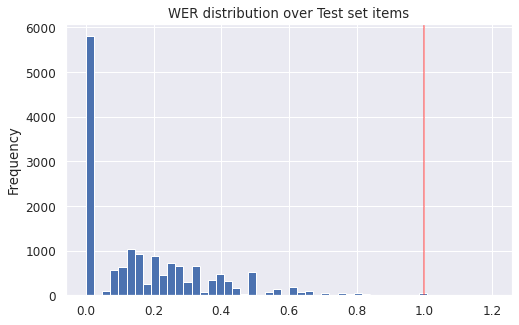

In [32]:
display(df_results['wer'].describe())

df_results['wer'].plot.hist(bins=50, figsize=(8, 5));
plt.title('WER distribution over Test set items');
plt.axvline(1, color='red', alpha=0.5);